In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# ANOVA - Theory

## One-factor model

$$
Y_{ij} = \mu + \tau_i + \epsilon_{ij}
$$

- The global mean $\mu$ is independent of the factor variable
- The $i$-th factor effect $\tau_i$ describes the influence of the factor level $i$ on the response variable
- The term $\epsilon_{ij}$ constitutes the random error.

**Assumptions about the error**

- Independend and normally distributed
- Have a mean of 0
- All errors have the same variance $\sigma^2$

## Hypothesis

$$
H_0: \tau_1 = \tau_2 = \dots = \tau_k = 0
$$
$$
H_1: \text{ There is at least one } i \text{ such that } \tau_i \neq 0
$$

## Test statistic

$$
\begin{align}
SS_T &= SS_{Treat} + SS_E \\
SS_T &= \sum_{i = 1}^k \sum_{j = 1}^n (y_{ij} - \bar{y}_{..})^2 \\
SS_T &= n * \sum_{i=1}^k (\bar{y}_{i.} - \bar{y}_{..})^2 + \sum_{i=1}^k \sum_{j=1}^n(y_{ij} - \bar{y}_{i.})^2
\end{align}
$$

where $\bar{y}_{i.}$ is the group mean and $\bar{y}_{..}$ is the grand mean

## ANOVA - Analysis of variance

$$
\begin{align}
MS_{Treat} &= \frac{1}{k-1} * SS_{Treat} \\
MS_{E} &= \frac{1}{k(n-1)} * SS_E \\
F &= \frac{MS_{Treat}}{MS_E}
\end{align}
$$


## Estimation of effects

- Estimation of the global mean $\mu$ $$\hat{\mu} = \frac{1}{k*n} \sum_{i=1}^k \sum_{j = 1}^n y_{ij}$$
- Estimation for the group means $$\hat{\mu}_i = \frac{1}{n} \sum_{j = 1}^n y_{ij}$$
- Calculate estimators for the treatments $\tau_i$ $$\hat{\tau}_i = \hat{\mu}_i - \hat{\mu}$$

## Analysis of residuals

$$
e_{ij} = y_{ij} - \hat{\mu} - \hat{\tau}_i = y_{ij} - y_i
$$

The residuals $e_{ij}$ have the following properties

- Mean of 0
- Residuals grouped according to the factor level have an equal variance $\sigma^2$
- Residuals are approximately normally distributed

In [2]:
def anova_from_df(df: pd.DataFrame, alpha: float) -> None:
    """
    Analysis of variance based on a given DataFrame where the columns
    represent the k different groups (factors) and the rows the n
    different observations (replicates).
    The function calculates all the different parameters and shows the
    graphical visualization of the data.
    
    Args:
        df (pd.DataFrame): DataFrame with the data
        alpha (float): Level of significance. E. g. 0.05 for alpha=5%
    """
    arr = df.to_numpy()
    k = arr.shape[1]
    n = arr.shape[0]
    group_mean = arr.mean(axis=0)
    grand_mean = np.mean(group_mean)
    
    ss_treat = n * np.sum((group_mean - grand_mean) ** 2)
    ss_e = np.sum([np.sum((arr[:, i] - group_mean[i]) ** 2) for i in range(k)])
    ss_t = ss_treat + ss_e
    ms_treat = 1 / (k - 1) * ss_treat
    ms_e = 1 / (k * (n - 1)) * ss_e
    f = ms_treat / ms_e
    
    p_value = 1 - stats.f(k - 1, k * (n - 1)).cdf(f)
    is_significant = p_value < alpha
    
    tau = group_mean - grand_mean
    
    # Check the residuals
    r = arr - group_mean
    
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax[0, 0].boxplot(arr, patch_artist=True, labels=df.columns)
    ax[0, 0].set_title("Boxplot of raw data")
    ax[0, 0].grid()
    
    stats.probplot(arr.reshape(-1), plot=ax[0, 1], dist=stats.distributions.norm)
    ax[0, 1].set_title("Q-Q-plot of raw data")
    ax[0, 1].grid()
    
    ax[1, 0].boxplot(r, patch_artist=True, labels=df.columns)
    ax[1, 0].set_title("Boxplots of residuals")
    ax[1, 0].grid()
    
    stats.probplot(r.reshape(-1), plot=ax[1, 1], dist=stats.distributions.norm)
    ax[1, 1].set_title("Q-Q-plot of residuals (normality)")
    ax[1, 1].grid()
    
    plt.subplots_adjust(hspace=0.25)
    
    print("ANOVA RESULTS\n")
    print(f"SSt     = {ss_t}")
    print(f"SStreat = {ss_treat}")
    print(f"SSe     = {ss_e}")
    print(f"MStreat = {ms_treat}")
    print(f"MSe     = {ms_e}")
    print(f"F       = {f}")
    print(f"p-value = {p_value}")
    print(f"taus    = {tau}")
    print(f"Grand µ = {grand_mean}")

    if is_significant:
        print("There is a significant difference between the groups\n")
    else:
        print("There is no significant difference between the groups\n")
        
    print("GRAPHICAL VISUALIZATION")
    plt.show()

In [3]:
path = "Viagra.txt"

In [4]:
df = pd.read_csv(path)
df.head()

,Placebo,LowDose,HighDose
0,3,5,7
1,2,2,4
2,1,4,5
3,1,2,3
4,4,3,6


ANOVA RESULTS

SSt     = 43.733333333333334
SStreat = 20.133333333333333
SSe     = 23.6
MStreat = 10.066666666666666
MSe     = 1.9666666666666668
F       = 5.11864406779661
p-value = 0.024694289538222614
taus    = [-1.26666667 -0.26666667  1.53333333]
Grand µ = 3.466666666666667
There is a significant difference between the groups

GRAPHICAL VISUALIZATION


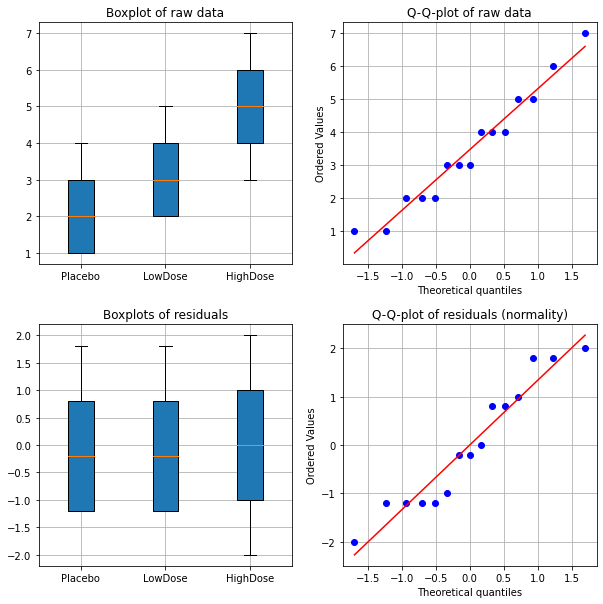

In [5]:
anova_from_df(df, 0.05)

In [6]:
def anova_from_data(nb_groups: int,
                    nb_replicats: int,
                    group_sum: np.ndarray,
                    group_means: np.ndarray,
                    grand_mean: float,
                    squared_diff: np.ndarray,
                    ss_t: float = None,
                    ss_e: float = None,
                    alpha: float = 0.05) -> None:
    """
    Function calculates the ANOVA based on certain parameters
    from the data
    
    Args:
        nb_groups (int): Number of groups. Refers to k.
        nb_replicats (int): Number of values per group. Refers to n.
        group_sum (np.ndarray): Sum of the different groups
        group_means (np.ndarray): Mean values of the different groups
        grand_mean (np.ndarray): Overall average of the test-score
        squared_diff (np.ndarray): Squared differences between
            the group mean and the grand mean
        ss_t (float): Total sum of squared. (Defaults to None).
        ss_e (float): Squared sum of errors. (Defaults to None).
        alpha (float): Level of significance. (Defaults to 0.05).
    
    Remarks:
        Either ss_t or ss_e must be given
    """
    assert group_sum.shape == group_means.shape == squard_diff.shape, \
        "The number of values in the arrays must be identical"

    assert ss_t or ss_e, "Either SSt or SSe must be given"
    
    ss_treat = nb_replicats * np.sum((group_means - grand_mean) ** 2)
    if ss_t is None:
        ss_t = ss_treat + ss_e
    elif ss_e is None:
        ss_e = ss_t - ss_treat
    
    ms_treat = 1 / (nb_groups - 1) * ss_treat
    ms_e = 1 / (nb_groups * (nb_replicats - 1)) * ss_e
    f = ms_treat / ms_e
    
    p_value = 1 - stats.f(nb_groups - 1, nb_groups * (nb_replicats - 1)).cdf(f)
    is_significant = p_value < alpha
    
    tau = group_means - grand_mean
    
    print("ANOVA RESULTS\n")
    print(f"SSt     = {ss_t}")
    print(f"SStreat = {ss_treat}")
    print(f"SSe     = {ss_e}")
    print(f"MStreat = {ms_treat}")
    print(f"MSe     = {ms_e}")
    print(f"F       = {f}")
    print(f"p-value = {p_value}")
    print(f"taus    = {tau}")
    print(f"Grand µ = {grand_mean}")

In [7]:
k = 3
n = 10
sum_of_scores = np.array([551, 574, 700])
mean_scores = np.array([55.1, 57.4, 70.0])
squard_diff = np.array([29.16, 9.61, 90.25])
grand_mean = 60.5
ss_t = 4353.24

In [8]:
anova_from_data(k, n, sum_of_scores, mean_scores, grand_mean, squard_diff, ss_t=ss_t, alpha=0.05)

ANOVA RESULTS

SSt     = 4353.24
SStreat = 1290.1999999999998
SSe     = 3063.04
MStreat = 645.0999999999999
MSe     = 113.44592592592592
F       = 5.686409580025073
p-value = 0.008691420703784591
taus    = [-5.4 -3.1  9.5]
Grand µ = 60.5
